# Laboratorium

### Konfiguracja

In [24]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [25]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


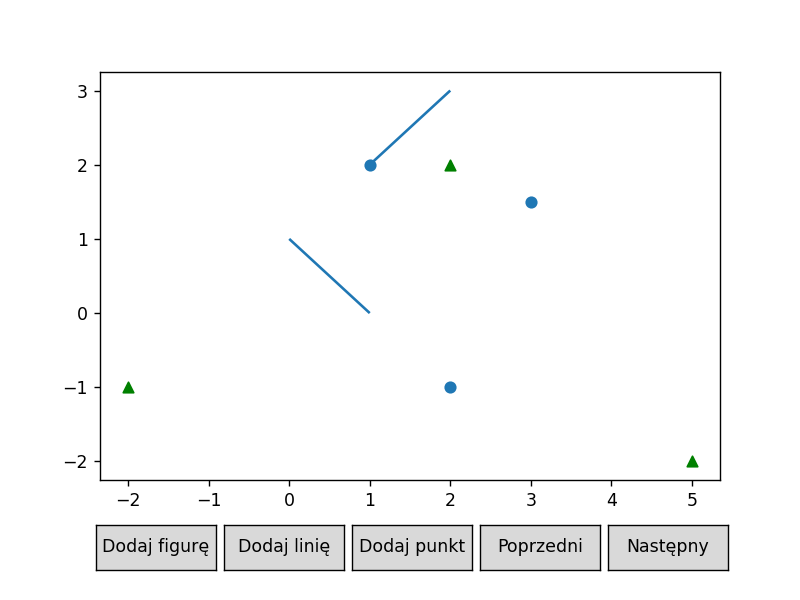

In [26]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


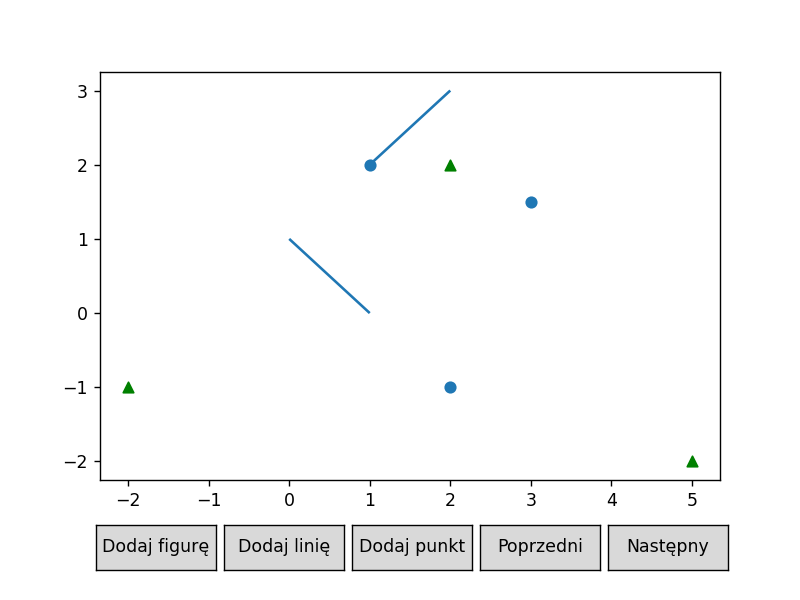

In [27]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


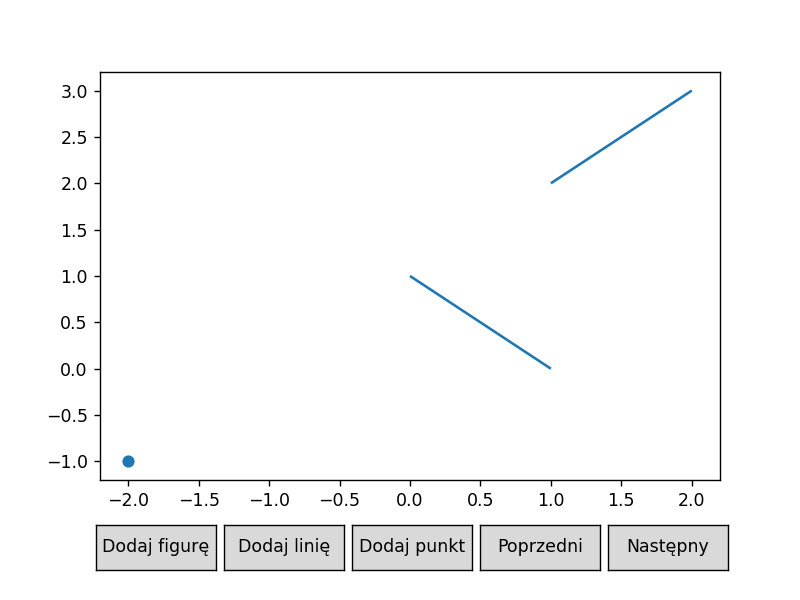

In [28]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


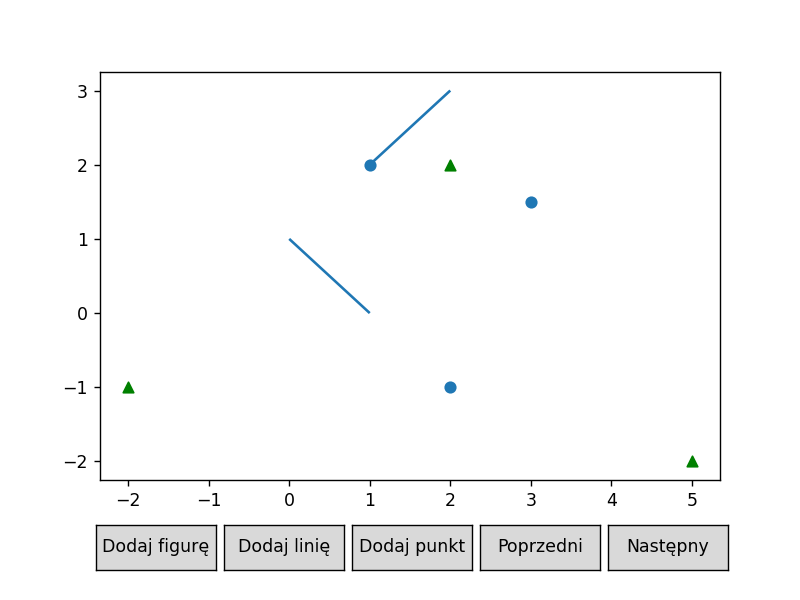

In [29]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


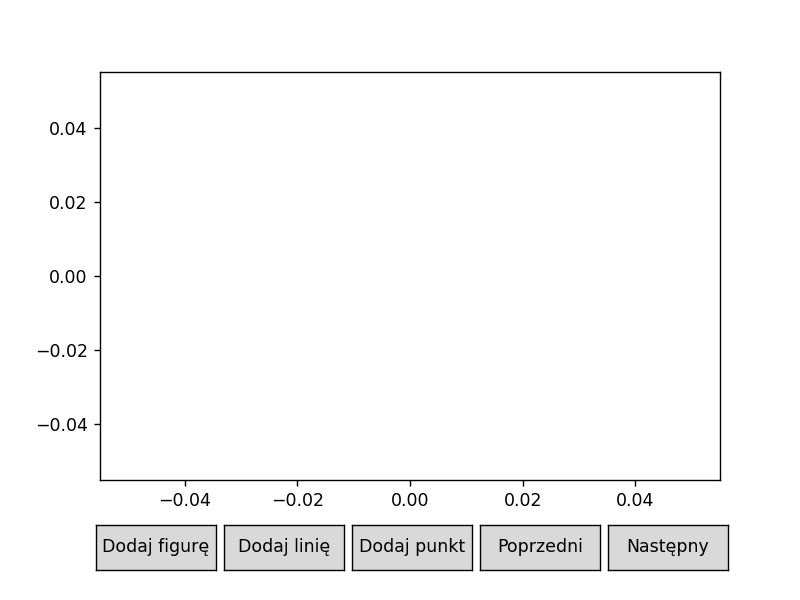

In [30]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


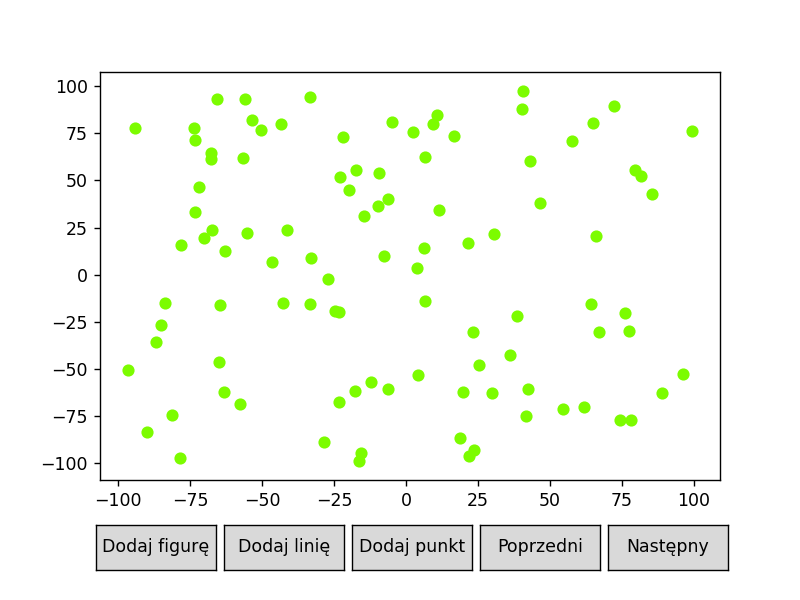

In [31]:
%matplotlib notebook

#zad 1 a)
dots=[]
for i in range(100):
        dots.append([np.random.uniform(-100, 100),np.random.uniform(-100, 100)])
plot1_1 = Plot(points=[PointsCollection(dots, color='lawngreen')])
plot1_1.draw()



<IPython.core.display.Javascript object>


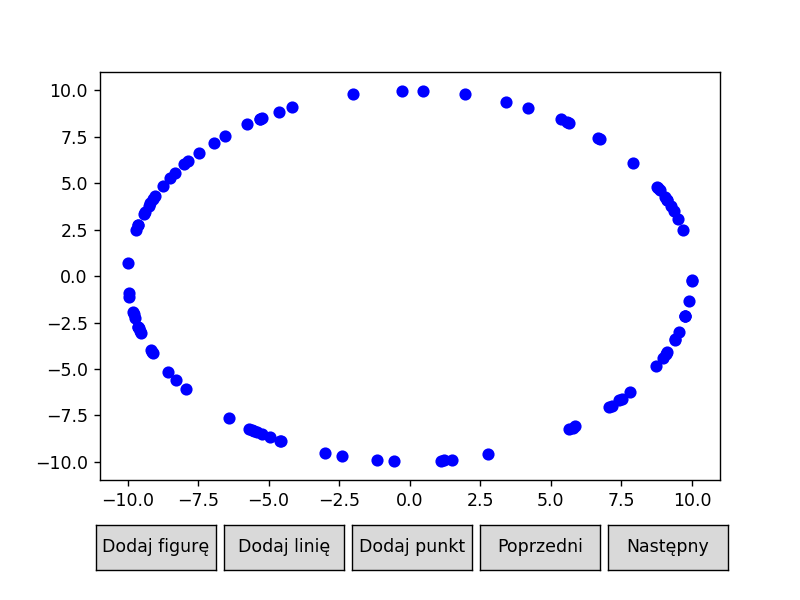

In [32]:
# zad 1 b)
def create_circle(radius,array):
    for i in range(len(array)):
        point=2 * np.pi * np.random.random_sample()
        array[i]=[radius * np.cos(point), radius * np.sin(point)]
circle = [None]*100
create_circle(10,circle)
plot1_2=Plot(points=[PointsCollection(circle, color='blue')])
plot1_2.draw()

<IPython.core.display.Javascript object>


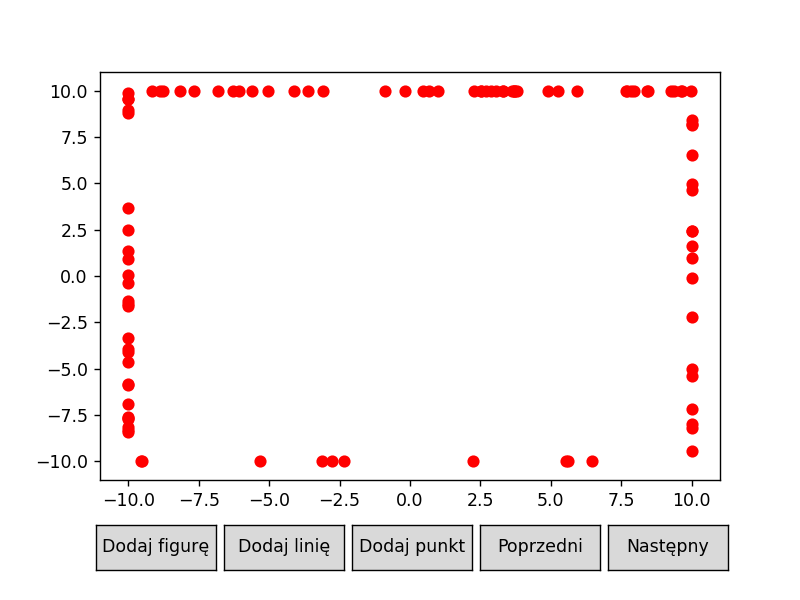

In [33]:
# zad 1 c)
import random
def create_rectangle(array,amount):
    for i in range(amount):
        side = random.randint(1,5)
        if side == 1:
            add_vertical(-10,array)
        elif side == 2:
            add_vertical(10,array)
        elif side == 3:
            add_horizontal(-10,array)
        else:
            add_horizontal(10,array)
    

def add_vertical(x,array):
        point = random.uniform(-10 , 10)
        array.append([x,point])
        
def add_horizontal(y,array):
    point = random.uniform(-10 , 10)
    array.append([point,y])
    

rectangle=[]
create_rectangle(rectangle,100)
plot1_3=Plot(points=[PointsCollection(rectangle, color='red')])
plot1_3.draw()

<IPython.core.display.Javascript object>


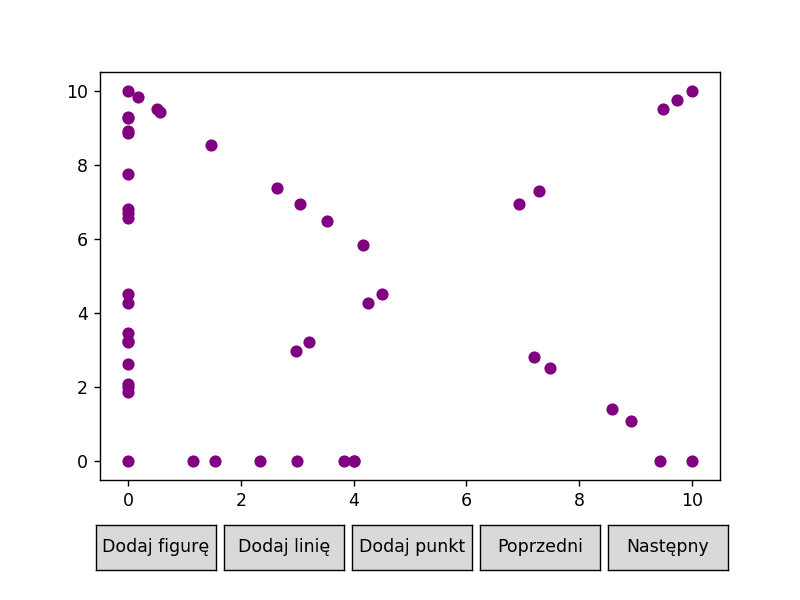

In [34]:
#zad1 d)

square=[]    
square.append([0,0])
square.append([0,10])
square.append([10,0])
square.append([10,10])

for i in range(25):
    point=random.uniform(0, 10)
    side = random.randint(1,3)
    if side == 1:
        square.append([point , 0])
    else:
        square.append([0,point])

for i in range(20):
    side = random.randint(1,3)
    x = random.uniform(0, 10)
    if side == 1:
        square.append([x,x])
    else:
        square.append([x,-x+10])
            
plot1_4=Plot(points=[PointsCollection(square, color='purple')])
plot1_4.draw()

<IPython.core.display.Javascript object>


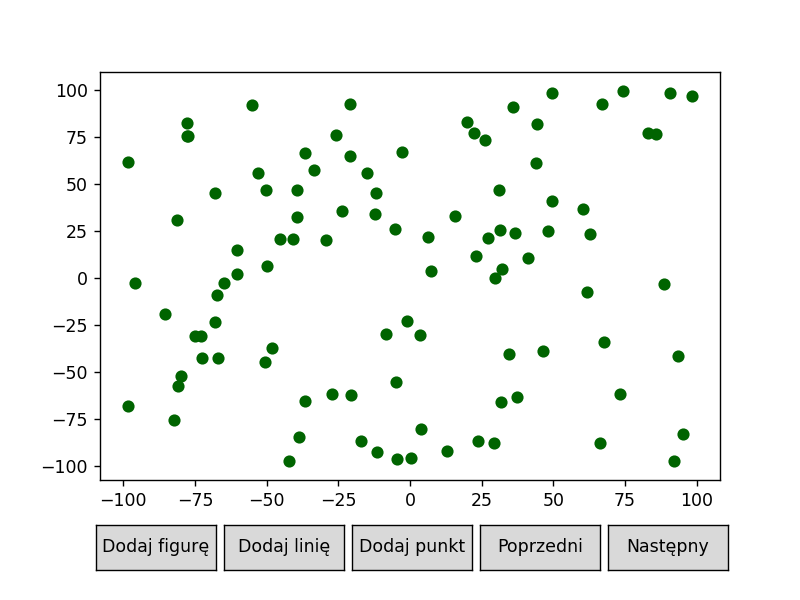

In [190]:
#zad3 a)

def generate_points(amount, left , right):
    array=[None]*amount
    for i in range(amount):
        array[i]=[np.random.uniform(left, right),np.random.uniform(left, right)]
    return array

dots_2 = generate_points(100,-100,100)

plot3_1 = Plot(points=[PointsCollection(dots_2, color='darkgreen')])
plot3_1.draw()

<IPython.core.display.Javascript object>


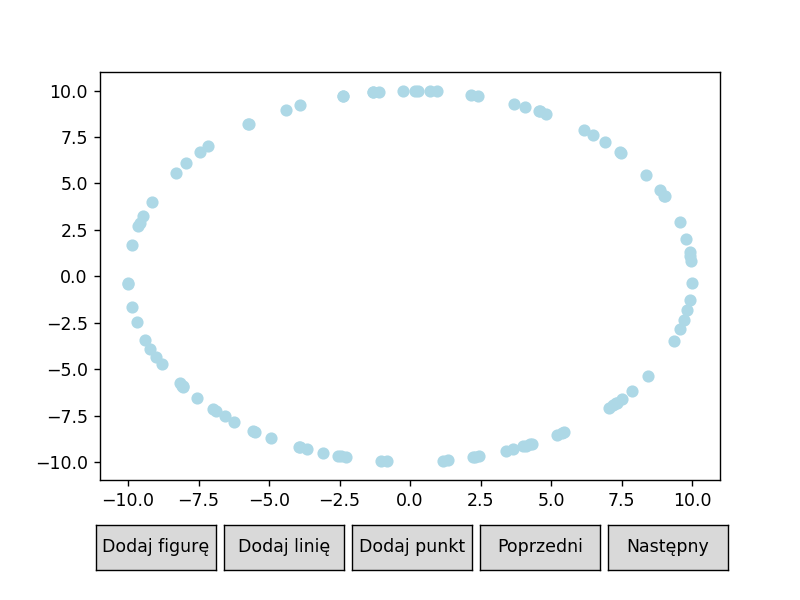

In [189]:
#zad3 b)
def create_specific_circle(amount,middle,radius):
    array=[]
    for i in range(amount):
        point=2 * np.pi * np.random.random_sample()
        array.append([radius * np.cos(point) + middle[0], radius * np.sin(point) + middle[1]])
    return array

spec_circle=create_specific_circle(100,[0,0],10)

plot3_2 = Plot(points=[PointsCollection(spec_circle, color='lightblue')])
plot3_2.draw()


        

<IPython.core.display.Javascript object>


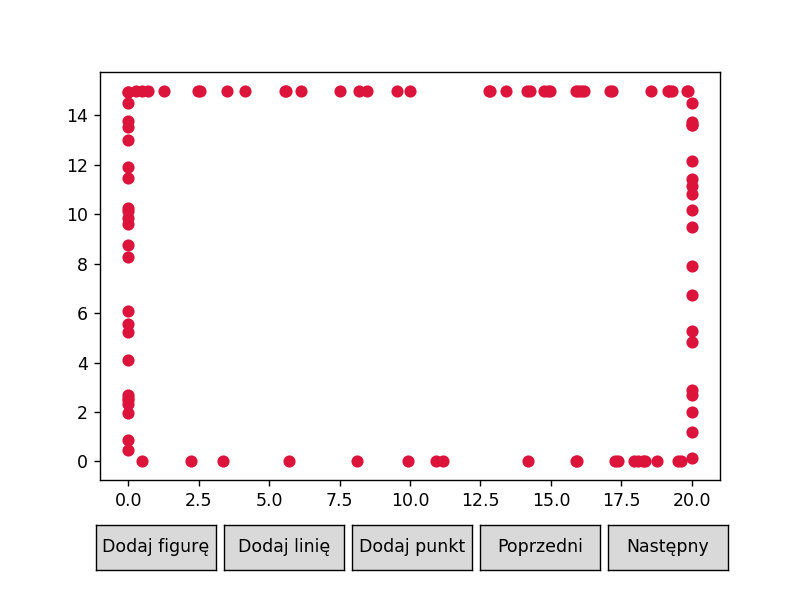

In [144]:
#zad3 c)

def create_specific_rectangle(amount,V):
    lx=V[0][0]
    rx=V[0][0]
    dy=V[0][1]
    uy=V[0][1]
    for i in range(1,4):
        if V[i][0] < lx:
            lx= V[i][0]
        if V[i][0] > rx:
            rx= V[i][0]
        if V[i][1] < dy:
            dy= V[i][1]
        if V[i][0] > uy:
            uy= V[i][1]
    array=[]
    
    def add_vertical(x,array):
            point = random.uniform(dy , uy)
            array.append([x,point])

    def add_horizontal(y,array):
        point = random.uniform(lx , rx)
        array.append([point,y])
        
    for i in range(amount):
        side = random.randint(1,5)
        if side == 1:
            add_vertical(lx,array)
        elif side == 2:
            add_vertical(rx,array)
        elif side == 3:
            add_horizontal(dy,array)
        else:
            add_horizontal(uy,array)
    return array
    
spec_rectangle=create_specific_rectangle(100,[[0,0] , [20,0] , [0,15] , [20,15]])
plot3_3=Plot(points=[PointsCollection(spec_rectangle, color='crimson')])
plot3_3.draw()

<IPython.core.display.Javascript object>


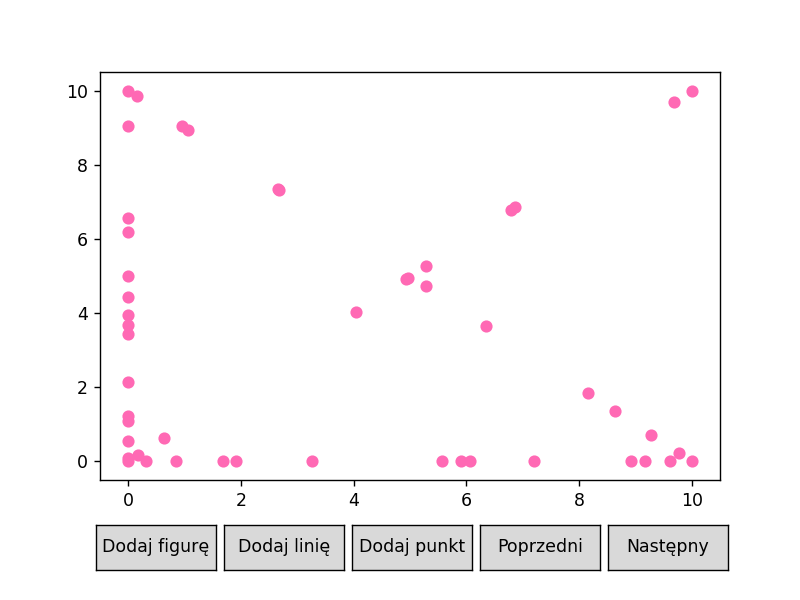

In [221]:
def create_specific_square(V,side,diagonal):
    array=[]
    for i in range(4):
        array.append(V[i])
    
    lx=V[0][0]
    rx=V[0][0]
    dy=V[0][1]
    uy=V[0][1]
    for i in range(1,4):
        if V[i][0] < lx:
            lx= V[i][0]
        if V[i][0] > rx:
            rx= V[i][0]
        if V[i][1] < dy:
            dy= V[i][1]
        if V[i][1] > uy:
            uy= V[i][1]
    
    
    for i in range(side):
        side = random.randint(1,3)
        if side == 1:
            point=random.uniform(lx, rx)
            array.append([point , dy])
        else:
            point=random.uniform(dy, uy)
            array.append([lx,point])
    
    for i in range(diagonal):
        side = random.randint(1,3)
        point=random.uniform(lx, rx)
        if side == 1:
            array.append([point,point+uy-rx])
        else:
            array.append([point,-point+lx+uy])
    return array
spec_square=create_specific_square([[0,0],[0,10],[10,0],[10,10]] , 25 ,20 )
plot3_4=Plot(points=[PointsCollection(spec_square, color='hotpink')])
plot3_4.draw()

In [188]:
#aby zapisać wynik do pliku należy wywołać funkcję z argumentem save = True oraz nazwą pliku docelowego
from functools import cmp_to_key
import copy
import time

def find_side(p1,p2,p3):
    ep= 10**(-8)
    side = (p2[1] - p1[1]) * (p3[0] - p2[0]) - (p2[0] - p1[0]) * (p3[1] - p2[1])
    
    if side < -1*ep:
        return 2
    
    elif side > ep:
        return 1
   
    else:
        return 0

def find_distance(p1,p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2


def graham_algo(points ,save = False , file_name='somefile.json'):
    array=copy.deepcopy(points)
    n=len(array)
    min_y = array[0][1]
    index=0
    for i in range(1,n):
        current = array[i][1]
        
        if (current < min_y) or (current == min_y and array[index][0] > array[i][0]):
            min_y = current
            index = i
    
    array[0] , array[index] = array[index] , array[0]
    p0=array[0]
    def compare(p1,p2):
        p0 = array[0]
        side = find_side(p0,p1,p2)

        if side == 0 and find_distance(p0,p1) <= find_distance(p0,p2):
            return -1
        if side ==  0 and find_distance(p0,p1) > find_distance(p0,p2):
            return 1
        if side == 1:
            return 1
        if side == 2:
            return -1
    
    array = sorted(array , key = cmp_to_key(compare))
    length = 1
    for i in range(1,n):
        
        while i < n-1 and find_side(p0 , array[i] , array[i+1]) == 0:
            i+=1
        array[length] = array[i]
        length += 1
    
    if length < 3 :
        print("Wyznaczenie otoczki niemożliwe")
        return
    else:
        p=[]
        scenes=[]
        lines=[]
        q=[]
    
        for i in range(3):
            q.append(array[i])
        
        lines.append([(q[0][0] , q[0][1]) , (q[1][0] ,q[1][1])])
        current_lines=copy.deepcopy(lines)
        scenes.append(Scene([PointsCollection(points, color='blue')], 
              [LinesCollection(lines = current_lines , color = 'black')])) 

        lines.append([(q[1][0] , q[1][1]) , (q[2][0] ,q[2][1])])
        p.append(q[1])
        current_p=copy.deepcopy(p)
        current_lines=copy.deepcopy(lines)
        current_dots=copy.deepcopy(q[:-1])
        scenes.append(Scene([PointsCollection(points, color='blue'),PointsCollection(current_p, color='yellow'),
                            PointsCollection(current_dots, color='slategray')],
              [LinesCollection(lines = current_lines , color = 'black') ,LinesCollection(lines = [current_lines[-1]] , color = 'red')]))

           
        for i in range(3,length):
            while  len(q) > 1 and find_side(q[-2] , q[-1] ,array[i]) != 2 :
                q.pop()
                lines.pop()
            lines.append([(q[-1][0] , q[-1][1]) , (array[i][0] ,array[i][1])])
            current_lines=copy.deepcopy(lines)
            p.pop()
            p.append(q[-1])
            current_p=copy.deepcopy(p)
            current_dots=copy.deepcopy(q[:-1])
            if len(current_lines) >= 2:
                branch = [current_lines[-1], current_lines[-2]]
            else:
                 branch = [current_lines[-1]]
            test_branch=copy.deepcopy(branch)
            scenes.append(Scene([PointsCollection(points, color='blue'), PointsCollection(current_p, color='yellow'),PointsCollection(current_dots, color='slategray')],
              [LinesCollection(lines = current_lines , color = 'black'),LinesCollection(lines = test_branch, color = 'red')]))
            q.append(array[i])
        lines.append([(q[-1][0] , q[-1][1]) , (q[0][0] ,q[0][1])])
        scenes.append(Scene([PointsCollection(points, color='blue') , PointsCollection(q, color='darkgreen')], 
              [LinesCollection(lines =lines , color = 'green')]))
        if save:
            final_set = Plot (points = [PointsCollection (q)])
            with open(file_name, 'w') as file:
                file.write(final_set.toJson())
        
        return scenes
    

            
        
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

Czas: 0.03s


<IPython.core.display.Javascript object>


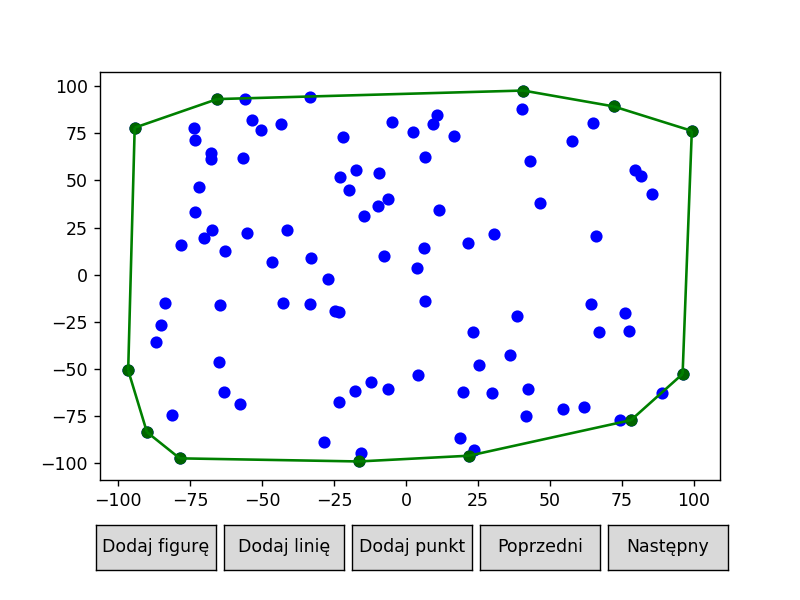

In [222]:
start=time.time()
scenes = graham_algo(dots)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()




Czas: 0.21s


<IPython.core.display.Javascript object>


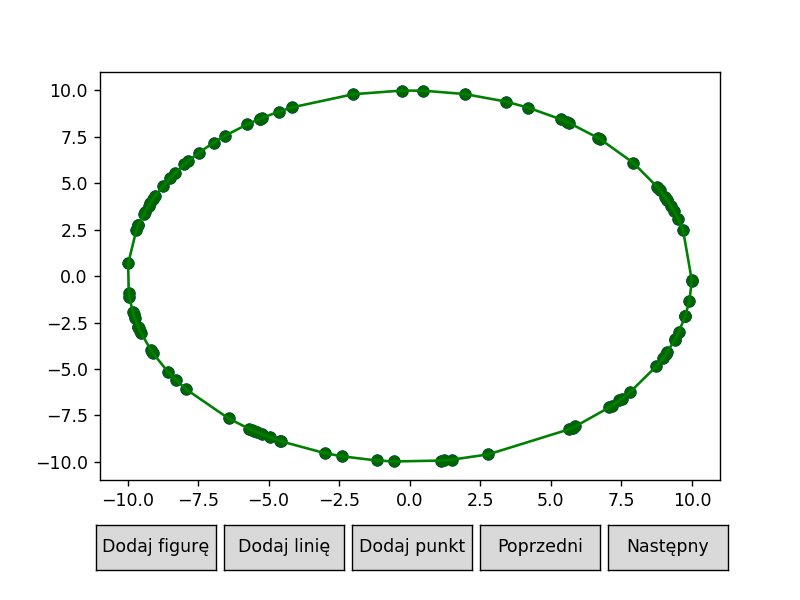

In [223]:
start=time.time()
scenes = graham_algo(circle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()


Czas: 0.02s


<IPython.core.display.Javascript object>


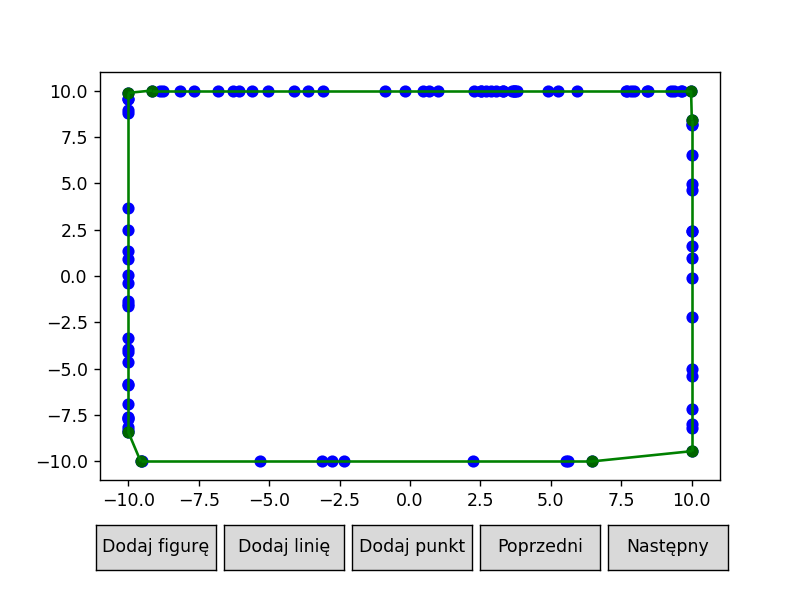

In [224]:
start=time.time()
scenes = graham_algo(rectangle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()


Czas: 0.01s


<IPython.core.display.Javascript object>


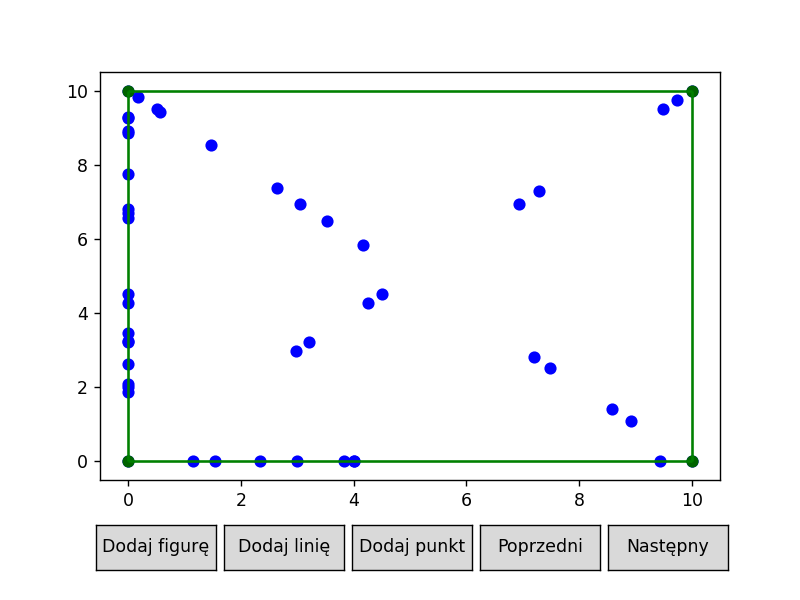

In [225]:
start=time.time()
scenes = graham_algo(square)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()


Czas: 0.03s


<IPython.core.display.Javascript object>


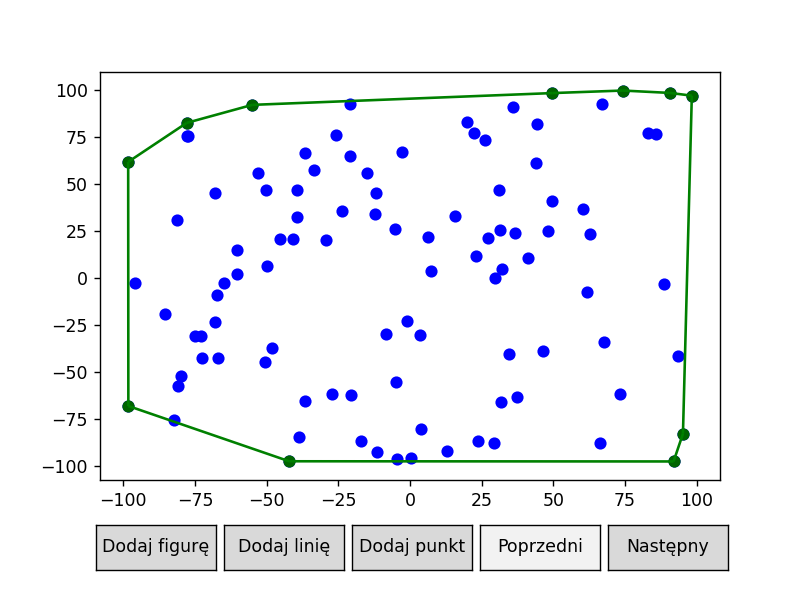

In [226]:
start=time.time()
scenes = graham_algo(dots_2)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()

Czas: 0.20s


<IPython.core.display.Javascript object>


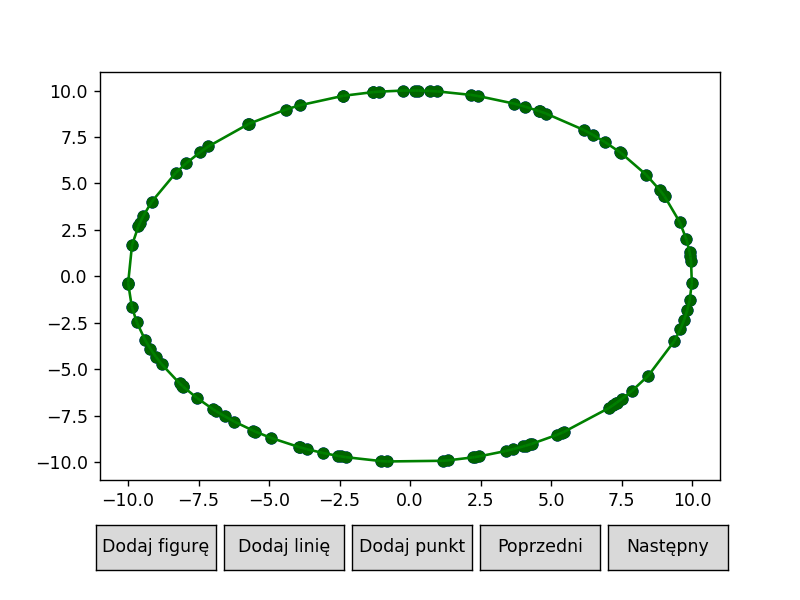

In [227]:
start=time.time()
scenes = graham_algo(spec_circle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()

Czas: 0.02s


<IPython.core.display.Javascript object>


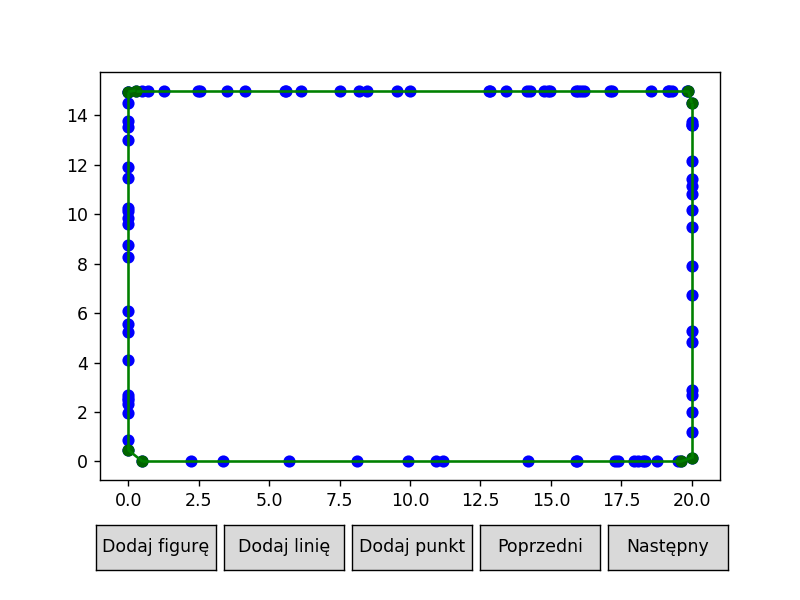

In [228]:
start=time.time()
scenes = graham_algo(spec_rectangle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()

Czas: 0.01s


<IPython.core.display.Javascript object>


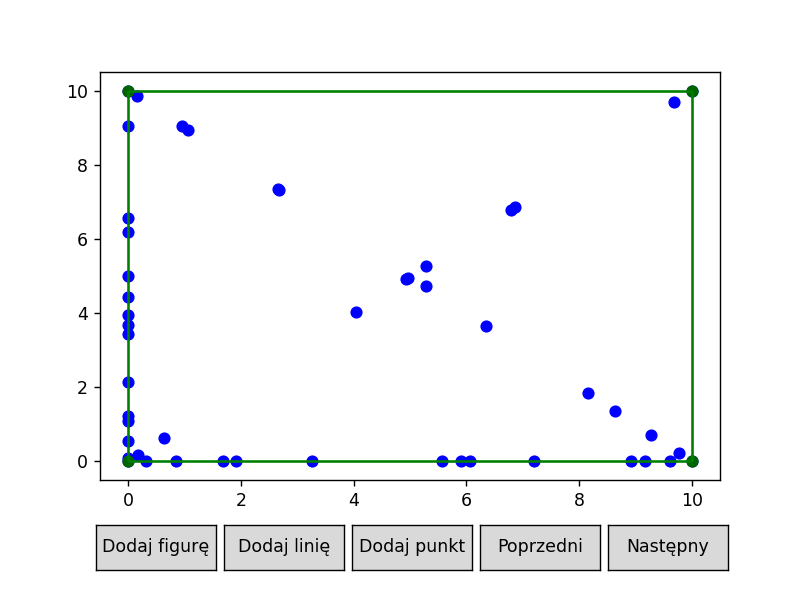

In [229]:
start=time.time()
scenes = graham_algo(spec_square)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot=Plot(scenes = scenes)
plot.draw()


In [230]:
#aby zapisać wynik do pliku należy wywołać funkcję z argumentem save = True oraz nazwą pliku docelowego
def jarvis_algo(points , save=False , file_name = 'somefile.json'):
    n=len(points)
    if n <3:
        print("Wyznaczenie otoczki niemożliwe")
        return
    
    scenes=[]
    p=[]  
    lines=[]
    q=[]
    
    min_x = points[0][0]
    points.sort(key = lambda x : x[0])
    index=0
    for i in range(1,n):
        current = points[i][0]
        
        if (current < min_x) or (current == min_x and points[index][1] > points[i][1]):
            min_y = current
            index = i
    
    prev = index
    path=[]
    
    while True:
        path.append(points[prev])
        if len(path) > 1:
            lines.append([(path[-2][0] , path[-2][1]) , (path[-1][0] , path[-1][1])])
        p.append(points[prev])
        current_dots=copy.deepcopy(p)
        current_lines=copy.deepcopy(lines)
        
        scenes.append(Scene([PointsCollection(points, color='blue'),PointsCollection(current_dots, color='slategray')],
              [LinesCollection(lines = current_lines , color = 'black')]))

        
        next = 1 
        
        for i in range(n):
            side = find_side(points[prev],points[i],points[next])
            if side == 2 or (side == 0 and find_distance(points[prev],points[i]) > find_distance(points[prev] , points[next])):
                branch = [(points[prev],points[i]) , (points[i],points[next])]
                test_branch=copy.deepcopy(branch)
                q=[points[i]]
                current_q=copy.deepcopy(q)
                
                
                scenes.append(Scene([PointsCollection(points, color='blue'), PointsCollection(current_q, color='yellow'),PointsCollection(current_dots, color='slategray')],
              [LinesCollection(lines = current_lines , color = 'black'),LinesCollection(lines = test_branch, color = 'red')]))
                next = i
        prev = next 
        
        if prev == index:
            break
    lines.append([(path[-1][0] , path[-1][1]) , (path[0][0] , path[0][1])])   
    scenes.append(Scene([PointsCollection(points, color='blue') , PointsCollection(p, color='darkgreen')], 
              [LinesCollection(lines =lines , color = 'green')]))   
    
    if save:
        final_set = Plot (points = [PointsCollection (path)])
        with open(file_name, 'w') as file:
            file.write(final_set.toJson())
    
    return scenes 

        
        
        











Czas: 0.01s


<IPython.core.display.Javascript object>


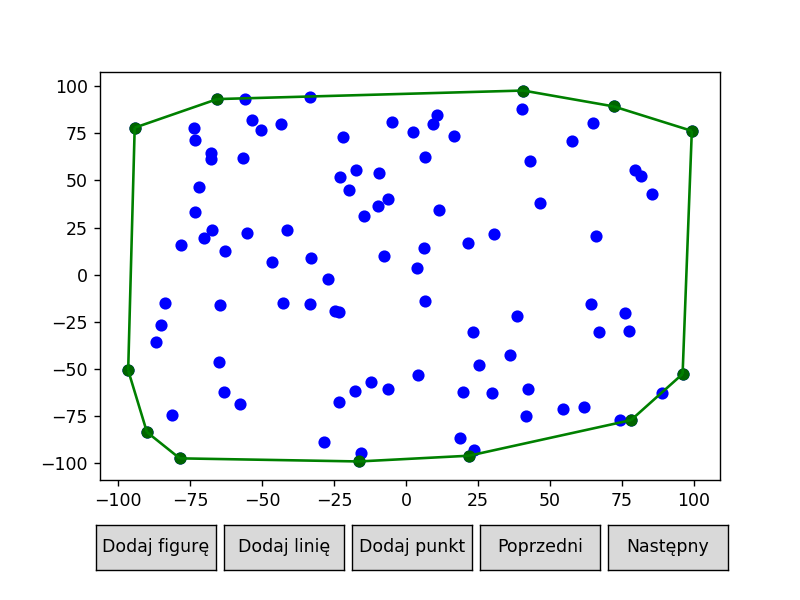

In [232]:
start=time.time()
scenes = jarvis_algo(dots)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()


Czas: 0.56s


<IPython.core.display.Javascript object>


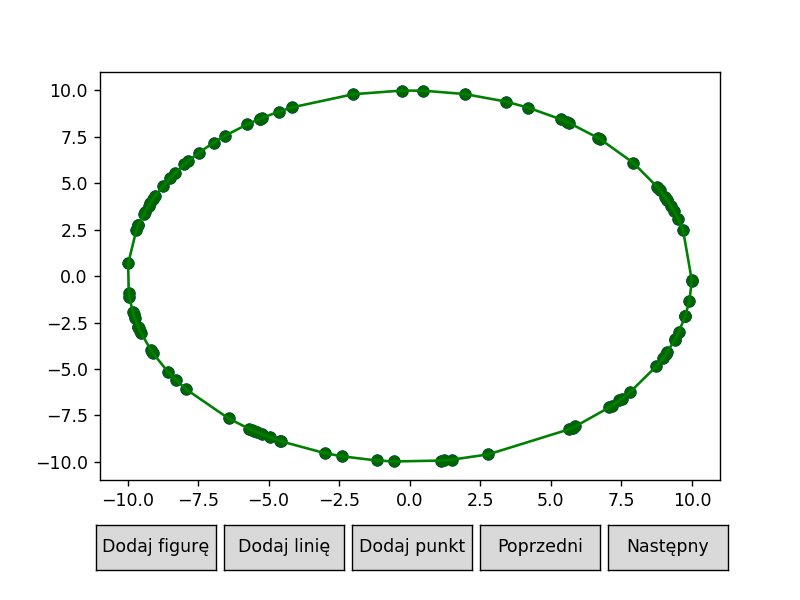

In [233]:
start=time.time()
scenes  = jarvis_algo(circle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()

Czas: 0.01s


<IPython.core.display.Javascript object>


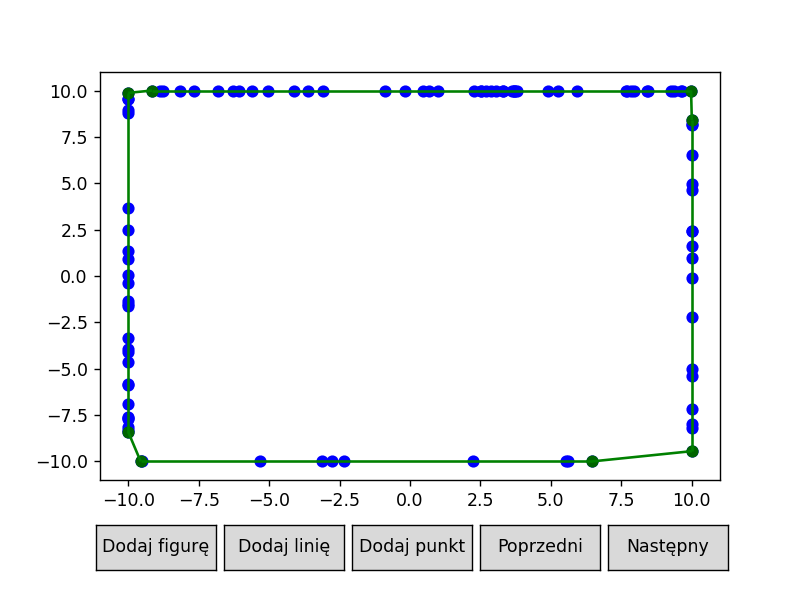

In [234]:
start=time.time()
scenes = jarvis_algo(rectangle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()


Czas: 0.00s


<IPython.core.display.Javascript object>


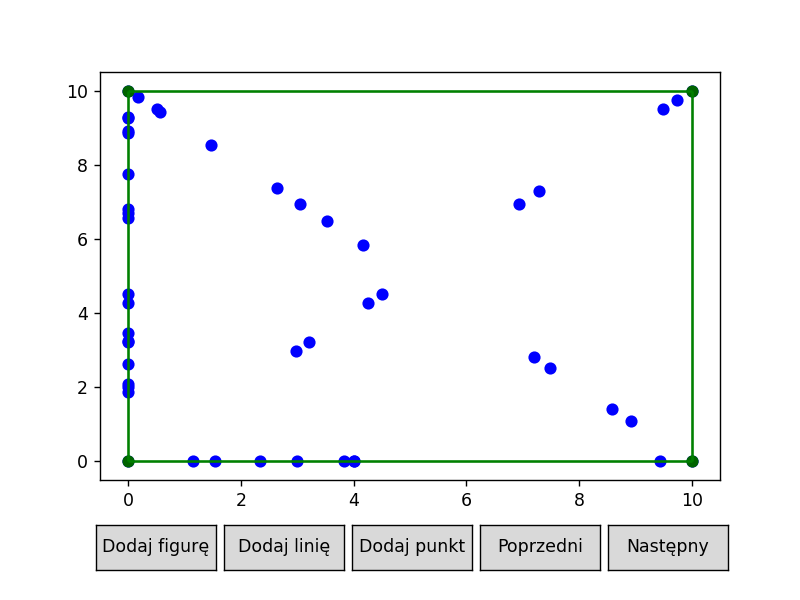

In [235]:
start=time.time()
scenes = jarvis_algo(square)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()

Czas: 0.01s


<IPython.core.display.Javascript object>


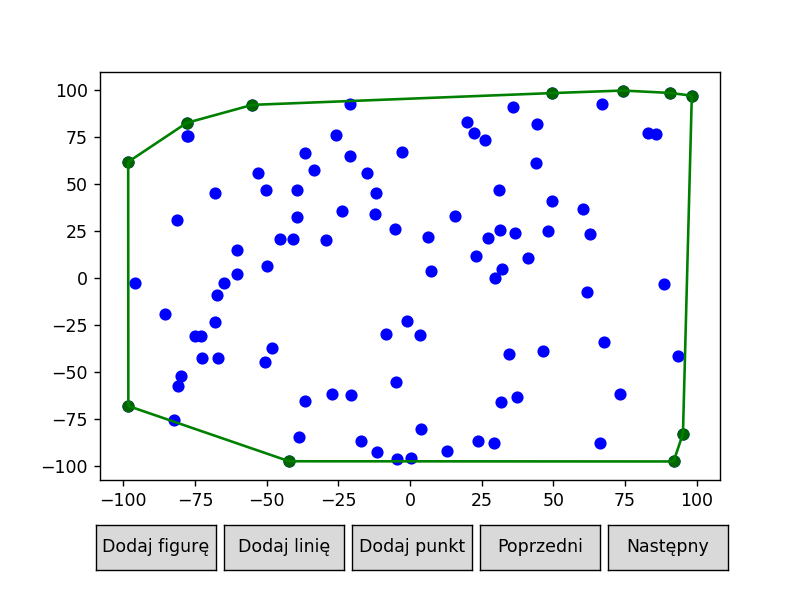

In [236]:
start=time.time()
scenes = jarvis_algo(dots_2)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()

Czas: 0.38s


<IPython.core.display.Javascript object>


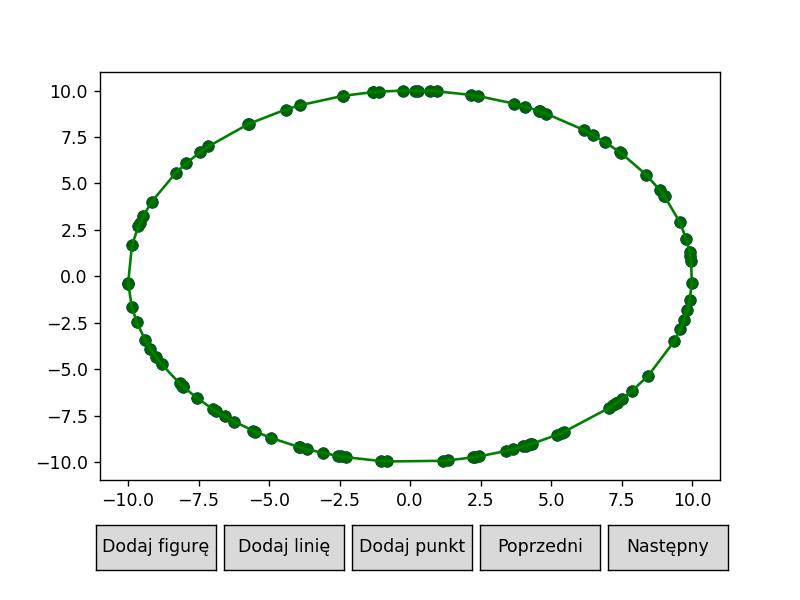

In [237]:
start=time.time()
scenes = jarvis_algo(spec_circle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()


Czas: 0.01s


<IPython.core.display.Javascript object>


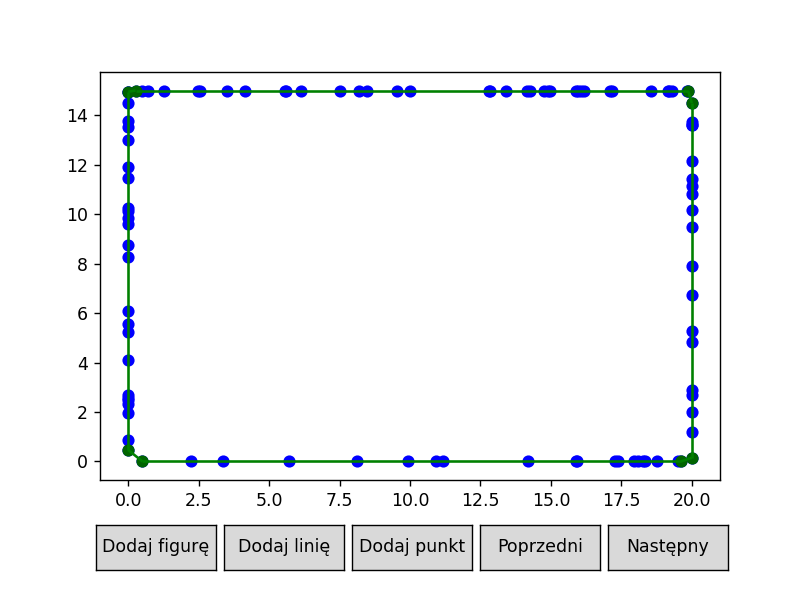

In [238]:
start=time.time()
scenes = jarvis_algo(spec_rectangle)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()


Czas: 0.00s


<IPython.core.display.Javascript object>


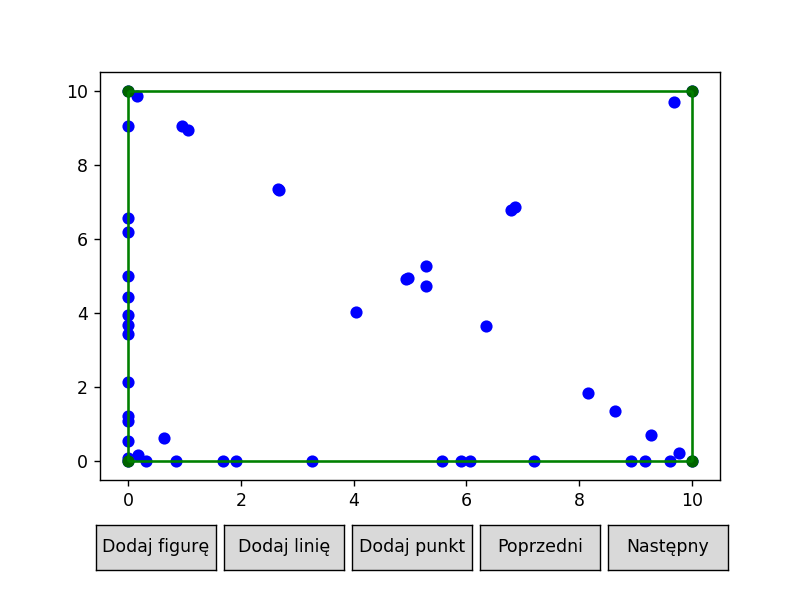

In [239]:
start=time.time()
scenes = jarvis_algo(spec_square)
finish=time.time()
print("Czas: %.2fs"  %(finish-start))
plot = Plot(scenes =scenes)
plot.draw()
